In [16]:
# Import required libraries
import os
import cv2
import torch
import clip
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for inline plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"OpenCV version: {cv2.__version__}")

Libraries imported successfully!
PyTorch version: 2.5.1
OpenCV version: 4.10.0


## Configuration and Setup

In [17]:
# Configuration
CLIP_MODEL = "ViT-B/32"
CONFIDENCE_THRESHOLD = 0.5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_ROOT = "./data/P-DESTRE/images/10-07-2019-1-5/img1/"
OUTPUT_DIR = "./detection_results/"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Device: {DEVICE}")
print(f"CLIP Model: {CLIP_MODEL}")
print(f"Data Root: {DATA_ROOT}")
print(f"Output Directory: {OUTPUT_DIR}")

Device: cpu
CLIP Model: ViT-B/32
Data Root: ./data/P-DESTRE/images/10-07-2019-1-5/img1/
Output Directory: ./detection_results/


## CLIP Model Loading and Text Embeddings

In [18]:
# Load CLIP model
print(f"Loading CLIP model: {CLIP_MODEL}")
clip_model, clip_preprocess = clip.load(CLIP_MODEL, device=DEVICE)
print("CLIP model loaded successfully!")

# Define gender classification prompts
gender_prompts = {
    0: [  # Male
        "a photo of a man",
        "a male person", 
        "a photo of a boy",
        "a masculine person"
    ],
    1: [  # Female  
        "a photo of a woman",
        "a female person",
        "a photo of a girl", 
        "a feminine person"
    ],
    2: [  # Unknown/Ambiguous
        "a person with unclear gender",
        "an androgynous person",
        "a person from behind"
    ]
}

print("Gender prompts defined:")
for gender_id, prompts in gender_prompts.items():
    gender_name = ["Male", "Female", "Unknown"][gender_id]
    print(f"  {gender_name}: {len(prompts)} prompts")

Loading CLIP model: ViT-B/32
CLIP model loaded successfully!
Gender prompts defined:
  Male: 4 prompts
  Female: 4 prompts
  Unknown: 3 prompts
CLIP model loaded successfully!
Gender prompts defined:
  Male: 4 prompts
  Female: 4 prompts
  Unknown: 3 prompts


In [19]:
# Precompute text embeddings for efficiency
print("Precomputing text embeddings...")
text_embeddings = {}

with torch.no_grad():
    for gender_id, prompts in gender_prompts.items():
        embeddings = []
        for prompt in prompts:
            text_tokens = clip.tokenize([prompt]).to(DEVICE)
            text_embedding = clip_model.encode_text(text_tokens)
            text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
            embeddings.append(text_embedding)
        
        # Average embeddings for each gender
        text_embeddings[gender_id] = torch.mean(torch.cat(embeddings, dim=0), dim=0, keepdim=True)

print(f"Text embeddings computed for {len(text_embeddings)} gender categories")
print(f"Embedding shape: {list(text_embeddings.values())[0].shape}")

Precomputing text embeddings...
Text embeddings computed for 3 gender categories
Embedding shape: torch.Size([1, 512])
Text embeddings computed for 3 gender categories
Embedding shape: torch.Size([1, 512])


## HOG People Detector Setup

In [20]:
# Initialize HOG people detector
print("Setting up HOG people detector...")
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
print("HOG detector initialized successfully!")

def detect_people_hog(image: np.ndarray) -> List[List[float]]:
    """
    Detect people using HOG descriptor.
    
    Args:
        image: Input image as numpy array
        
    Returns:
        List of bounding boxes [x1, y1, x2, y2] for detected people
    """
    # Resize image for better detection
    height, width = image.shape[:2]
    scale = 1.0
    if width > 640:
        scale = 640.0 / width
        new_width = int(width * scale)
        new_height = int(height * scale)
        resized_image = cv2.resize(image, (new_width, new_height))
    else:
        resized_image = image
    
    # Detect people
    (rects, weights) = hog.detectMultiScale(
        resized_image,
        winStride=(4, 4),
        padding=(8, 8),
        scale=1.05
    )
    
    # Convert rectangles to bounding boxes and scale back
    bboxes = []
    for (x, y, w, h) in rects:
        # Scale back to original image size
        x1 = int(x / scale)
        y1 = int(y / scale)
        x2 = int((x + w) / scale)
        y2 = int((y + h) / scale)
        
        # Ensure bbox is within image boundaries
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(width, x2), min(height, y2)
        
        if x2 > x1 and y2 > y1:  # Valid bbox
            bboxes.append([x1, y1, x2, y2])
    
    return bboxes

print("HOG detection function defined")

Setting up HOG people detector...
HOG detector initialized successfully!
HOG detection function defined


## CLIP Gender Classification Function

In [21]:
def classify_gender(image: np.ndarray, bboxes: List[List[float]]) -> List[Tuple[int, float]]:
    """
    Classify gender for each detected person using CLIP.
    
    Args:
        image: Input image
        bboxes: List of bounding boxes
        
    Returns:
        List of (predicted_gender, confidence) tuples
    """
    predictions = []
    
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        
        # Ensure bbox is within image boundaries
        h, w = image.shape[:2]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        
        # Skip invalid boxes
        if x2 <= x1 or y2 <= y1:
            predictions.append((2, 0.0))  # Unknown
            continue
        
        # Extract crop with some padding
        pad = 10
        crop_x1 = max(0, x1 - pad)
        crop_y1 = max(0, y1 - pad)
        crop_x2 = min(w, x2 + pad)
        crop_y2 = min(h, y2 + pad)
        
        crop = image[crop_y1:crop_y2, crop_x1:crop_x2]
        if crop.size == 0:
            predictions.append((2, 0.0))  # Unknown
            continue
        
        # Convert to PIL and preprocess for CLIP
        crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        crop_tensor = clip_preprocess(crop_pil).unsqueeze(0).to(DEVICE)
        
        # Get CLIP prediction
        with torch.no_grad():
            image_features = clip_model.encode_image(crop_tensor)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            # Compute similarities with each gender
            similarities = {}
            for gender_id, text_embedding in text_embeddings.items():
                similarity = torch.cosine_similarity(image_features, text_embedding, dim=-1)
                similarities[gender_id] = similarity.item()
            
            # Get best prediction
            predicted_gender = max(similarities.keys(), key=lambda k: similarities[k])
            confidence = similarities[predicted_gender]
            
            predictions.append((predicted_gender, confidence))
    
    return predictions

print("Gender classification function defined")

Gender classification function defined


## Main Processing Function

In [22]:
def process_image(image_path: str) -> Dict:
    """
    Process a single image: detect people and classify gender.
    
    Args:
        image_path: Path to input image
        
    Returns:
        Dictionary with results
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        return {"error": f"Could not load image: {image_path}"}
    
    print(f"Processing: {os.path.basename(image_path)}")
    print(f"Image shape: {image.shape}")
    
    # Detect people
    print("Detecting people...")
    bboxes = detect_people_hog(image)
    print(f"Found {len(bboxes)} people")
    
    if len(bboxes) == 0:
        return {
            "image_path": image_path,
            "detections": 0,
            "results": [],
            "image_shape": image.shape
        }
    
    # Classify gender for each detection
    print("Classifying gender...")
    predictions = classify_gender(image, bboxes)
    
    # Combine results
    results = []
    for i, (bbox, (gender, confidence)) in enumerate(zip(bboxes, predictions)):
        results.append({
            "person_id": i + 1,
            "bbox": bbox,
            "gender_pred": gender,
            "gender_label": ["Male", "Female", "Unknown"][gender],
            "confidence": confidence
        })
    
    return {
        "image_path": image_path,
        "detections": len(bboxes),
        "results": results,
        "image_shape": image.shape
    }

print("Main processing function defined")

Main processing function defined


In [ ]:
# Ground Truth Annotation Functions (Updated with GT Gender)
import pandas as pd

def load_gt_annotations(annotation_file: str) -> pd.DataFrame:
    """
    Load ground truth annotations from MOT format file.
    
    Args:
        annotation_file: Path to annotation file
        
    Returns:
        DataFrame with columns: frame, id, x, y, w, h, conf, x_3d, y_3d, z_3d, gt_gender, ...
    """
    # MOT format: frame, id, bb_left, bb_top, bb_width, bb_height, conf, x, y, z, gt_gender, ...
    columns = ['frame', 'id', 'x', 'y', 'w', 'h', 'conf', 'x_3d', 'y_3d', 'z_3d', 'gt_gender'] + [f'extra_{i}' for i in range(15)]
    
    try:
        df = pd.read_csv(annotation_file, header=None, names=columns)
        print(f"Loaded {len(df)} annotations from {annotation_file}")
        print(f"Frames: {df['frame'].min()}-{df['frame'].max()}")
        print(f"Unique IDs: {df['id'].nunique()}")
        
        # Show GT gender distribution
        gt_gender_counts = df['gt_gender'].value_counts().sort_index()
        print(f"GT Gender distribution: {dict(gt_gender_counts)}")
        print(f"  0=Male, 1=Female, 2=Unknown")
        
        return df
    except Exception as e:
        print(f"Error loading annotations: {e}")
        return pd.DataFrame()

def get_frame_annotations(annotations_df: pd.DataFrame, frame_number: int) -> pd.DataFrame:
    """Get annotations for a specific frame."""
    frame_annotations = annotations_df[annotations_df['frame'] == frame_number].copy()
    
    # Convert bounding box to x1, y1, x2, y2 format
    frame_annotations['x1'] = frame_annotations['x']
    frame_annotations['y1'] = frame_annotations['y'] 
    frame_annotations['x2'] = frame_annotations['x'] + frame_annotations['w']
    frame_annotations['y2'] = frame_annotations['y'] + frame_annotations['h']
    
    return frame_annotations

def process_image_with_gt_annotations(image_path: str, annotation_file: str, frame_number: int) -> Dict:
    """
    Process image using ground truth annotations instead of detection.
    
    IMPORTANT: GT provides bounding boxes AND gender labels, CLIP provides gender predictions!
    
    Args:
        image_path: Path to input image
        annotation_file: Path to annotation file
        frame_number: Frame number to process
        
    Returns:
        Dictionary with results including both GT and CLIP gender info
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        return {"error": f"Could not load image: {image_path}"}
    
    print(f"Processing: {os.path.basename(image_path)}")
    print(f"Image shape: {image.shape}")
    
    # Load annotations
    annotations_df = load_gt_annotations(annotation_file)
    if annotations_df.empty:
        return {"error": "Could not load annotations"}
    
    # Get annotations for this frame
    frame_annotations = get_frame_annotations(annotations_df, frame_number)
    print(f"Found {len(frame_annotations)} GT bounding boxes in frame {frame_number}")
    
    if len(frame_annotations) == 0:
        return {
            "image_path": image_path,
            "detections": 0,
            "results": [],
            "image_shape": image.shape,
            "frame_number": frame_number,
            "source": "ground_truth"
        }
    
    # Extract bounding boxes and GT gender
    bboxes = []
    person_ids = []
    gt_genders = []
    
    for _, annotation in frame_annotations.iterrows():
        x1, y1, x2, y2 = int(annotation['x1']), int(annotation['y1']), int(annotation['x2']), int(annotation['y2'])
        # Ensure bbox is within image boundaries
        h, w = image.shape[:2]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        
        if x2 > x1 and y2 > y1:  # Valid bbox
            bboxes.append([x1, y1, x2, y2])
            person_ids.append(int(annotation['id']))
            gt_genders.append(int(annotation['gt_gender']))  # Add GT gender
    
    print(f"Valid GT bounding boxes: {len(bboxes)}")
    
    # Show GT gender distribution for this frame
    frame_gt_gender_counts = {0: 0, 1: 0, 2: 0}
    for gt_gender in gt_genders:
        frame_gt_gender_counts[gt_gender] += 1
    print(f"GT Gender in this frame: Male={frame_gt_gender_counts[0]}, Female={frame_gt_gender_counts[1]}, Unknown={frame_gt_gender_counts[2]}")
    
    # Classify gender for each detection using CLIP
    print("🧠 Applying CLIP gender classification to each GT person crop...")
    clip_predictions = classify_gender(image, bboxes)
    
    # Combine results with both GT and CLIP gender info
    results = []
    for i, (bbox, person_id, gt_gender, (clip_gender, clip_confidence)) in enumerate(zip(bboxes, person_ids, gt_genders, clip_predictions)):
        results.append({
            "person_id": person_id,  # Use ground truth ID
            "bbox": bbox,
            "gt_gender": gt_gender,  # Ground truth gender (0=Male, 1=Female, 2=Unknown)
            "gt_gender_label": ["Male", "Female", "Unknown"][gt_gender],
            "clip_gender_pred": clip_gender,  # CLIP prediction
            "clip_gender_label": ["Male", "Female", "Unknown"][clip_gender],
            "clip_confidence": clip_confidence,
            # Check if GT and CLIP agree
            "gender_match": gt_gender == clip_gender
        })
    
    return {
        "image_path": image_path,
        "detections": len(bboxes),
        "results": results,
        "image_shape": image.shape,
        "frame_number": frame_number,
        "source": "ground_truth"
    }

def visualize_results_with_gt(image_path: str, results: Dict, save_output: bool = True):
    """
    Visualize ground truth bounding boxes with both GT gender and CLIP predictions.
    
    LEGEND:
    - Bounding boxes = Ground Truth (human annotated)
    - GT Gender labels = Ground Truth (human annotated) 
    - CLIP Gender labels = CLIP predictions (AI generated)
    - Colors: Blue=Male, Red=Female, Gray=Unknown (based on CLIP prediction)
    - Border style: Solid=Match, Dashed=Mismatch between GT and CLIP
    """
    if "error" in results:
        print(f"Error: {results['error']}")
        return
    
    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create visualization
    plt.figure(figsize=(18, 12))
    plt.imshow(image_rgb)
    
    colors = ['blue', 'red', 'gray']  # Male, Female, Unknown (for CLIP predictions)
    labels = ['Male', 'Female', 'Unknown']
    
    # Statistics
    total_people = len(results['results'])
    matches = sum(1 for r in results['results'] if r['gender_match'])
    match_rate = (matches / total_people * 100) if total_people > 0 else 0
    
    # Draw bounding boxes and labels
    for result in results['results']:
        bbox = result['bbox']
        gt_gender = result['gt_gender']
        gt_gender_label = result['gt_gender_label']
        clip_gender = result['clip_gender_pred']
        clip_gender_label = result['clip_gender_label']
        clip_confidence = result['clip_confidence']
        person_id = result['person_id']
        is_match = result['gender_match']
        
        x1, y1, x2, y2 = bbox
        color = colors[clip_gender]  # Color based on CLIP prediction
        
        # Border style: solid if match, dashed if mismatch
        line_style = '-' if is_match else '--'
        line_width = 4 if is_match else 3
        
        # Draw rectangle
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, edgecolor=color, linewidth=line_width,
                           linestyle=line_style)
        plt.gca().add_patch(rect)
        
        # Create label showing both GT and CLIP
        match_symbol = "✓" if is_match else "✗"
        label_text = f"ID{person_id}: GT→{gt_gender_label} | CLIP→{clip_gender_label}({clip_confidence:.2f}) {match_symbol}"
        
        # Add label
        plt.text(x1, y1-20, label_text, 
                color=color, fontsize=11, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9))
    
    frame_num = results.get("frame_number", "Unknown")
    plt.title(f'Ground Truth vs CLIP Gender Classification\\nFrame {frame_num}: {total_people} people | Match Rate: {match_rate:.1f}% ({matches}/{total_people})\\n' +
              f'📍Boxes=GT | 👤GT Labels=Human | 🧠CLIP=AI | ✓=Match | ✗=Mismatch', 
              fontsize=14)
    plt.axis('off')
    
    # Add comprehensive legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='blue', alpha=0.7, label='CLIP: Male'),
        plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.7, label='CLIP: Female'), 
        plt.Rectangle((0,0),1,1, facecolor='gray', alpha=0.7, label='CLIP: Unknown'),
        plt.Rectangle((0,0),1,1, facecolor='none', edgecolor='black', linewidth=3, label='GT✓CLIP: Match'),
        plt.Rectangle((0,0),1,1, facecolor='none', edgecolor='black', linewidth=2, linestyle='--', label='GT✗CLIP: Mismatch')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=11)
    
    if save_output:
        output_path = os.path.join(OUTPUT_DIR, f"gt_vs_clip_frame_{frame_num}.png")
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {output_path}")
    
    plt.show()
    
    # Print detailed summary
    print(f"\\n{'='*80}")
    print(f"📊 GT vs CLIP GENDER CLASSIFICATION COMPARISON")
    print(f"{'='*80}")
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Frame number: {frame_num}")
    print(f"Image shape: {results['image_shape']}")
    print(f"📍 GT bounding boxes: {results['detections']} (human annotated)")
    print(f"👤 GT gender labels: {results['detections']} (human annotated)")
    print(f"🧠 CLIP gender predictions: {results['detections']} (AI generated)")
    
    if results['detections'] > 0:
        # GT Gender distribution
        gt_gender_counts = {'Male': 0, 'Female': 0, 'Unknown': 0}
        clip_gender_counts = {'Male': 0, 'Female': 0, 'Unknown': 0}
        
        for result in results['results']:
            gt_gender_counts[result['gt_gender_label']] += 1
            clip_gender_counts[result['clip_gender_label']] += 1
        
        print(f"\\n👤 Ground Truth Gender Distribution:")
        for gender, count in gt_gender_counts.items():
            print(f"  - {gender}: {count}")
        
        print(f"\\n🧠 CLIP Gender Predictions:")
        for gender, count in clip_gender_counts.items():
            print(f"  - {gender}: {count}")
        
        print(f"\\n🎯 Accuracy Analysis:")
        print(f"  - Total people: {total_people}")
        print(f"  - Matches (GT = CLIP): {matches}")
        print(f"  - Mismatches (GT ≠ CLIP): {total_people - matches}")
        print(f"  - Accuracy: {match_rate:.1f}%")
        
        print(f"\\n📋 Detailed Results:")
        for result in results['results']:
            bbox = result['bbox']
            match_status = "✓ MATCH" if result['gender_match'] else "✗ MISMATCH"
            print(f"  📍 GT-ID {result['person_id']}: 👤 GT={result['gt_gender_label']} | 🧠 CLIP={result['clip_gender_label']} "
                  f"(conf: {result['clip_confidence']:.3f}) | {match_status}")

print("✅ Updated ground truth annotation functions with GT gender!")
print("👤 GT Gender: 0=Male, 1=Female, 2=Unknown (human annotated)")
print("🧠 CLIP Gender: Male/Female/Unknown predictions (AI generated)")

Ground truth annotation functions defined!


## Visualization Function

In [23]:
def visualize_results(image_path: str, results: Dict, save_output: bool = True):
    """
    Visualize detection and classification results.
    
    Args:
        image_path: Path to input image
        results: Results from process_image
        save_output: Whether to save the visualization
    """
    if "error" in results:
        print(f"Error: {results['error']}")
        return
    
    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    plt.imshow(image_rgb)
    
    colors = ['blue', 'red', 'gray']  # Male, Female, Unknown
    labels = ['Male', 'Female', 'Unknown']
    
    # Draw bounding boxes and labels
    for result in results['results']:
        bbox = result['bbox']
        gender = result['gender_pred']
        confidence = result['confidence']
        person_id = result['person_id']
        
        x1, y1, x2, y2 = bbox
        color = colors[gender]
        label = labels[gender]
        
        # Draw rectangle
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, edgecolor=color, linewidth=3)
        plt.gca().add_patch(rect)
        
        # Add label
        plt.text(x1, y1-10, f"Person {person_id}: {label} ({confidence:.2f})", 
                color=color, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    plt.title(f'CLIP Gender Classification Results\n{os.path.basename(image_path)} - {results["detections"]} people detected')
    plt.axis('off')
    
    if save_output:
        output_path = os.path.join(OUTPUT_DIR, f"results_{os.path.splitext(os.path.basename(image_path))[0]}.png")
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {output_path}")
    
    plt.show()
    
    # Print detailed summary
    print(f"\n{'='*60}")
    print(f"RESULTS SUMMARY")
    print(f"{'='*60}")
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Image shape: {results['image_shape']}")
    print(f"Total detections: {results['detections']}")
    
    if results['detections'] > 0:
        gender_counts = {'Male': 0, 'Female': 0, 'Unknown': 0}
        for result in results['results']:
            gender_counts[result['gender_label']] += 1
        
        print(f"Gender breakdown:")
        for gender, count in gender_counts.items():
            print(f"  - {gender}: {count}")
        
        print(f"\nDetailed results:")
        for result in results['results']:
            bbox = result['bbox']
            print(f"  Person {result['person_id']}: {result['gender_label']} "
                  f"(conf: {result['confidence']:.3f}, bbox: {bbox})")

print("Visualization function defined")

Visualization function defined


## Testing on P-DESTRE Dataset

Let's test our CLIP gender classification system on real P-DESTRE images.

In [24]:
# Check available images
if os.path.exists(DATA_ROOT):
    image_files = [f for f in os.listdir(DATA_ROOT) if f.endswith('.jpg')]
    image_files.sort()
    print(f"Found {len(image_files)} images in {DATA_ROOT}")
    print(f"First 10 images: {image_files[:10]}")
    print(f"Last 10 images: {image_files[-10:]}")
else:
    print(f"Data directory not found: {DATA_ROOT}")
    print("Please update DATA_ROOT to point to your P-DESTRE image directory")

Found 2482 images in ./data/P-DESTRE/images/10-07-2019-1-5/img1/
First 10 images: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg']
Last 10 images: ['002473.jpg', '002474.jpg', '002475.jpg', '002476.jpg', '002477.jpg', '002478.jpg', '002479.jpg', '002480.jpg', '002481.jpg', '002482.jpg']


### Test Frame 1

Processing Frame 1 with Ground Truth annotations...
Processing: 000001.jpg
Image shape: (2160, 3840, 3)
Loaded 33419 annotations from /pfs/work9/workspace/scratch/ma_ighidaya-thesis_ignatio/MOTIP/data/P-DESTRE/annotations/10-07-2019-1-5.txt
Frames: 1-2482
Unique IDs: 26
Found 11 people in frame 1
Valid bounding boxes: 11
Classifying gender with CLIP...
Loaded 33419 annotations from /pfs/work9/workspace/scratch/ma_ighidaya-thesis_ignatio/MOTIP/data/P-DESTRE/annotations/10-07-2019-1-5.txt
Frames: 1-2482
Unique IDs: 26
Found 11 people in frame 1
Valid bounding boxes: 11
Classifying gender with CLIP...


Visualization saved to: ./detection_results/gt_results_000001.png


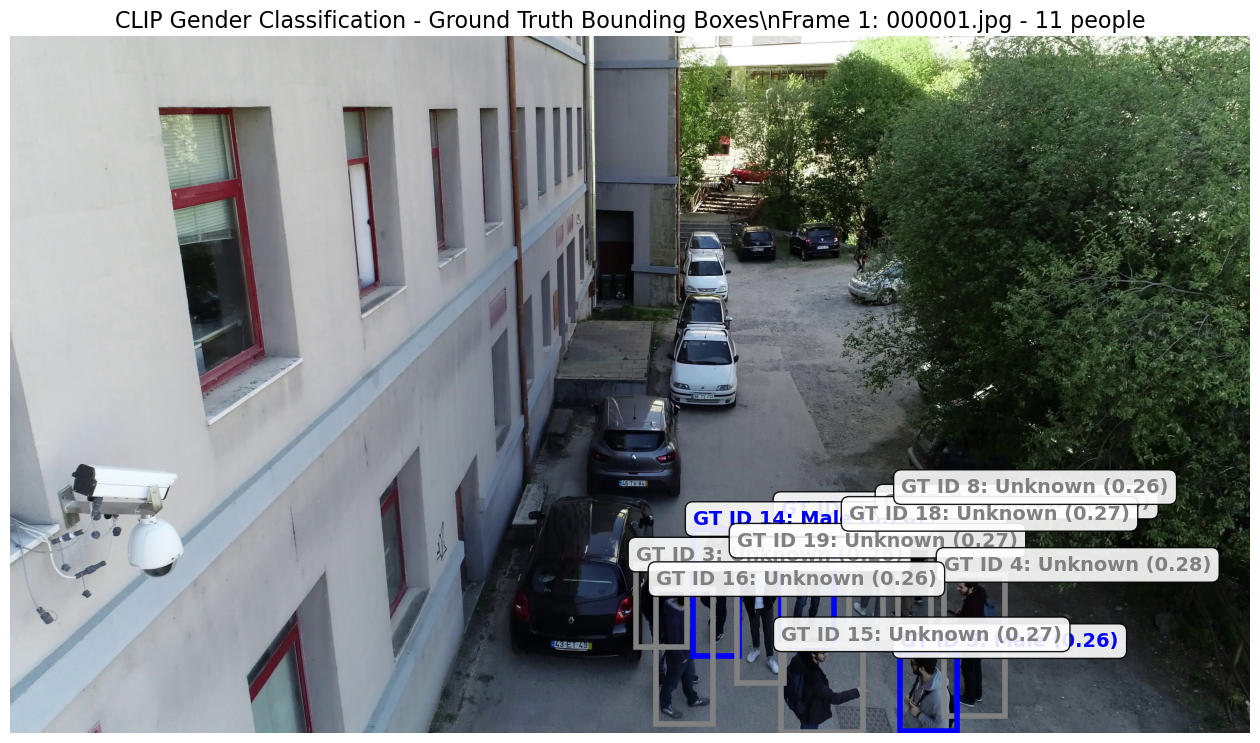

\n============================================================
GROUND TRUTH RESULTS SUMMARY
Image: 000001.jpg
Frame number: 1
Image shape: (2160, 3840, 3)
Total detections: 11
Source: ground_truth
Gender breakdown:
  - Male: 3
  - Female: 0
  - Unknown: 8
\nDetailed results:
  GT ID 6: Male (conf: 0.260, bbox: [2387, 1498, 2551, 1891])
  GT ID 14: Male (conf: 0.263, bbox: [2115, 1529, 2256, 1920])
  GT ID 3: Unknown (conf: 0.263, bbox: [1938, 1639, 2097, 1892])
  GT ID 19: Unknown (conf: 0.275, bbox: [2251, 1596, 2395, 2006])
  GT ID 4: Unknown (conf: 0.279, bbox: [2892, 1671, 3081, 2107])
  GT ID 7: Unknown (conf: 0.277, bbox: [2703, 1475, 2851, 1849])
  GT ID 18: Unknown (conf: 0.269, bbox: [2598, 1513, 2750, 1863])
  GT ID 5: Male (conf: 0.257, bbox: [2757, 1907, 2931, 2153])
  GT ID 16: Unknown (conf: 0.264, bbox: [2000, 1715, 2178, 2131])
  GT ID 15: Unknown (conf: 0.268, bbox: [2388, 1886, 2642, 2155])
  GT ID 8: Unknown (conf: 0.264, bbox: [2760, 1430, 2868, 1585])


In [29]:
# Test Frame 1 with Ground Truth Annotations
test_frame_1 = 1
test_image_1_gt = os.path.join(DATA_ROOT, f"{test_frame_1:06d}.jpg")
annotation_file = "/pfs/work9/workspace/scratch/ma_ighidaya-thesis_ignatio/MOTIP/data/P-DESTRE/annotations/10-07-2019-1-5.txt"

if os.path.exists(test_image_1_gt) and os.path.exists(annotation_file):
    print("Processing Frame 1 with Ground Truth annotations...")
    results_1_gt = process_image_with_gt_annotations(test_image_1_gt, annotation_file, frame_number=test_frame_1)
    visualize_results_with_gt(test_image_1_gt, results_1_gt)
else:
    print(f"Test image or annotations not found")
    print(f"Image: {test_image_1_gt}")
    print(f"Annotations: {annotation_file}")

### Test Frame 100

Processing Frame 100 with Ground Truth annotations...
Processing: 000100.jpg
Image shape: (2160, 3840, 3)
Loaded 33419 annotations from /pfs/work9/workspace/scratch/ma_ighidaya-thesis_ignatio/MOTIP/data/P-DESTRE/annotations/10-07-2019-1-5.txt
Frames: 1-2482
Unique IDs: 26
Found 13 people in frame 100
Valid bounding boxes: 13
Classifying gender with CLIP...
Visualization saved to: ./detection_results/gt_results_000100.png
Visualization saved to: ./detection_results/gt_results_000100.png


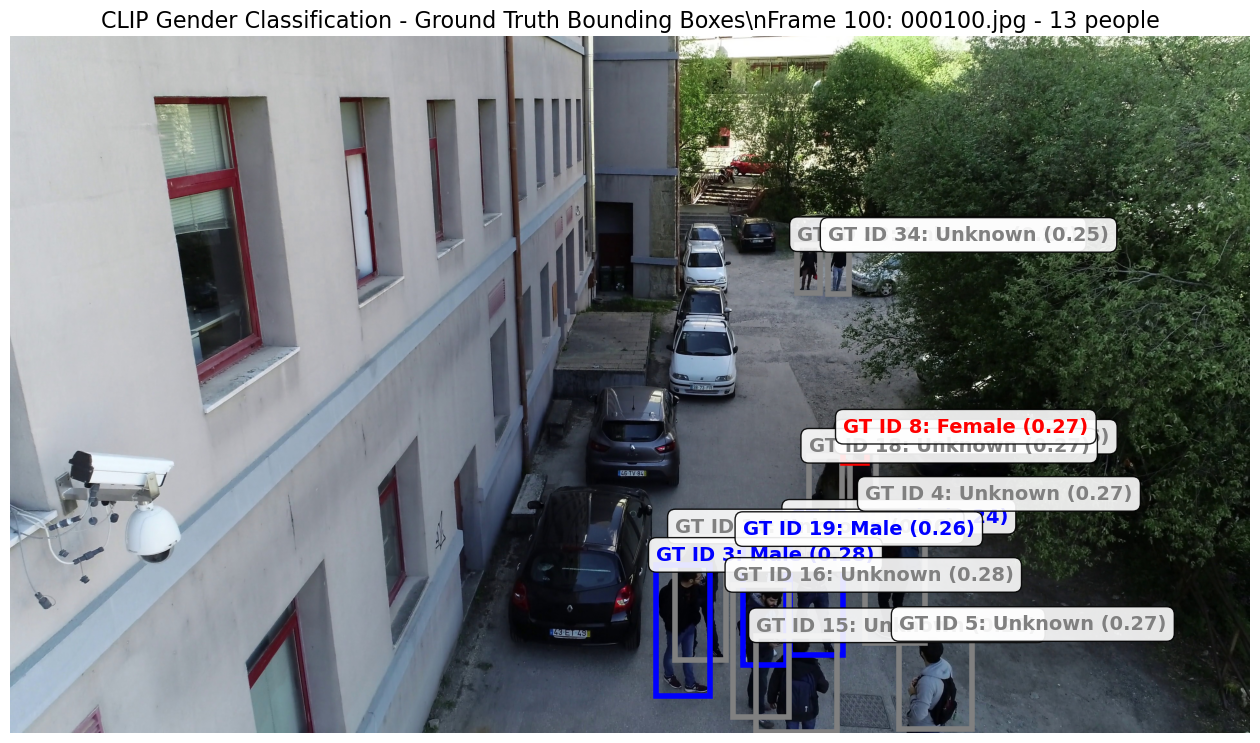

\n============================================================
GROUND TRUTH RESULTS SUMMARY
Image: 000100.jpg
Frame number: 100
Image shape: (2160, 3840, 3)
Total detections: 13
Source: ground_truth
Gender breakdown:
  - Male: 3
  - Female: 1
  - Unknown: 9
\nDetailed results:
  GT ID 6: Male (conf: 0.243, bbox: [2414, 1522, 2578, 1918])
  GT ID 14: Unknown (conf: 0.262, bbox: [2060, 1552, 2218, 1932])
  GT ID 3: Male (conf: 0.275, bbox: [2001, 1640, 2168, 2046])
  GT ID 19: Male (conf: 0.257, bbox: [2269, 1560, 2403, 1948])
  GT ID 4: Unknown (conf: 0.268, bbox: [2648, 1451, 2832, 1881])
  GT ID 7: Unknown (conf: 0.262, bbox: [2576, 1274, 2681, 1608])
  GT ID 18: Unknown (conf: 0.267, bbox: [2473, 1302, 2601, 1591])
  GT ID 16: Unknown (conf: 0.282, bbox: [2238, 1702, 2413, 2109])
  GT ID 8: Female (conf: 0.266, bbox: [2580, 1243, 2652, 1323])
  GT ID 33: Unknown (conf: 0.267, bbox: [2438, 647, 2509, 797])
  GT ID 34: Unknown (conf: 0.254, bbox: [2533, 649, 2598, 799])
  GT ID 15: Unk

In [30]:
# Test Frame 100 with Ground Truth
test_frame_2 = 100  
test_image_2_gt = os.path.join(DATA_ROOT, f"{test_frame_2:06d}.jpg")

if os.path.exists(test_image_2_gt):
    print("Processing Frame 100 with Ground Truth annotations...")
    results_2_gt = process_image_with_gt_annotations(test_image_2_gt, annotation_file, frame_number=test_frame_2)
    visualize_results_with_gt(test_image_2_gt, results_2_gt)
else:
    print(f"Test image not found: {test_image_2_gt}")

### Test Frame 500 (Middle of Sequence)

Processing Frame 500 with Ground Truth annotations...
Processing: 000500.jpg
Image shape: (2160, 3840, 3)
Loaded 33419 annotations from /pfs/work9/workspace/scratch/ma_ighidaya-thesis_ignatio/MOTIP/data/P-DESTRE/annotations/10-07-2019-1-5.txt
Frames: 1-2482
Unique IDs: 26
Found 13 people in frame 500
Valid bounding boxes: 13
Classifying gender with CLIP...
Visualization saved to: ./detection_results/gt_results_000500.png
Visualization saved to: ./detection_results/gt_results_000500.png


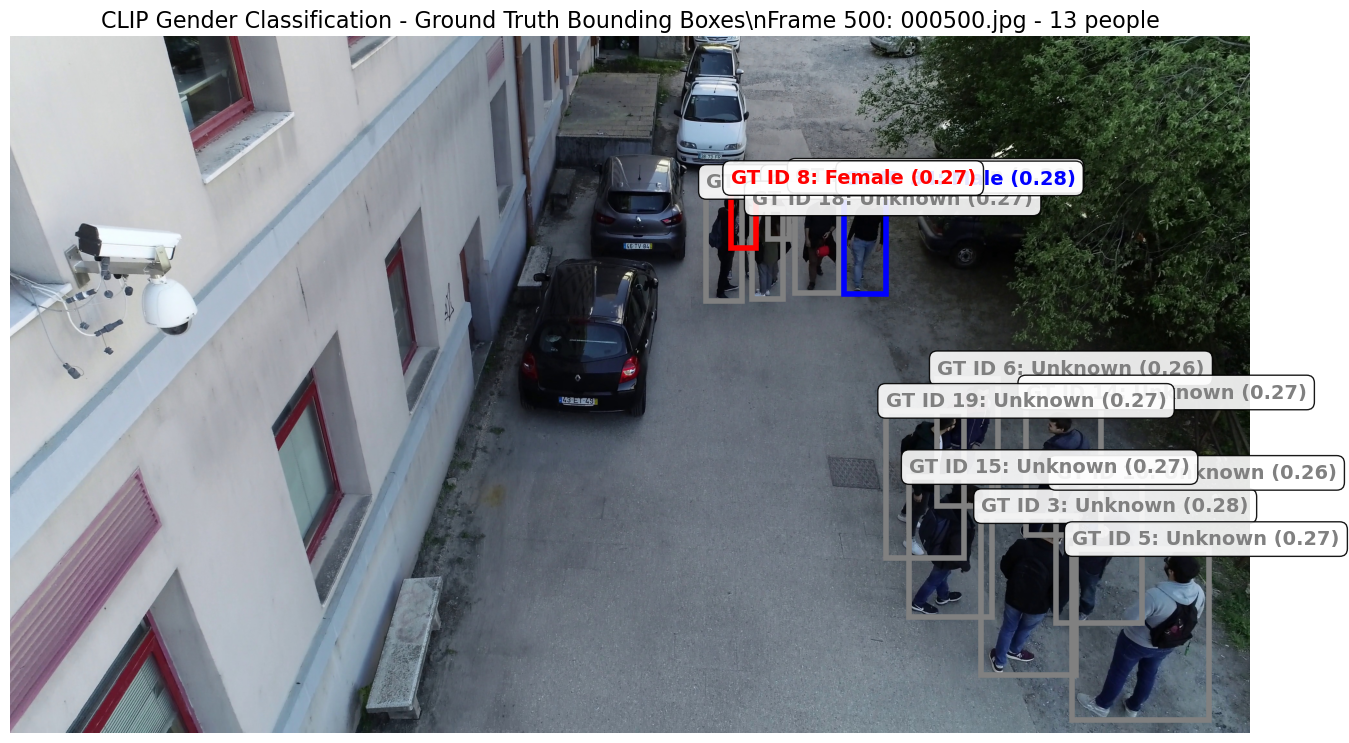

\n============================================================
GROUND TRUTH RESULTS SUMMARY
Image: 000500.jpg
Frame number: 500
Image shape: (2160, 3840, 3)
Total detections: 13
Source: ground_truth
Gender breakdown:
  - Male: 1
  - Female: 1
  - Unknown: 11
\nDetailed results:
  GT ID 6: Unknown (conf: 0.262, bbox: [2871, 1062, 3058, 1456])
  GT ID 14: Unknown (conf: 0.271, bbox: [3145, 1137, 3377, 1547])
  GT ID 3: Unknown (conf: 0.276, bbox: [3008, 1489, 3300, 1979])
  GT ID 19: Unknown (conf: 0.271, bbox: [2711, 1163, 2954, 1618])
  GT ID 4: Unknown (conf: 0.287, bbox: [2156, 485, 2266, 821])
  GT ID 7: Unknown (conf: 0.259, bbox: [2348, 485, 2413, 630])
  GT ID 18: Unknown (conf: 0.273, bbox: [2298, 536, 2394, 816])
  GT ID 16: Unknown (conf: 0.264, bbox: [3238, 1386, 3506, 1819])
  GT ID 33: Unknown (conf: 0.288, bbox: [2431, 466, 2566, 797])
  GT ID 34: Male (conf: 0.277, bbox: [2581, 474, 2713, 801])
  GT ID 15: Unknown (conf: 0.271, bbox: [2784, 1368, 3041, 1800])
  GT ID 5: U

In [31]:
# Test Frame 500 with Ground Truth
test_frame_3 = 500
test_image_3_gt = os.path.join(DATA_ROOT, f"{test_frame_3:06d}.jpg")

if os.path.exists(test_image_3_gt):
    print("Processing Frame 500 with Ground Truth annotations...")
    results_3_gt = process_image_with_gt_annotations(test_image_3_gt, annotation_file, frame_number=test_frame_3)
    visualize_results_with_gt(test_image_3_gt, results_3_gt)
else:
    print(f"Test image not found: {test_image_3_gt}")

### Test Frame 1200 (Later in Sequence)

Processing Frame 1200 with Ground Truth annotations...
Processing: 001200.jpg
Image shape: (2160, 3840, 3)
Processing: 001200.jpg
Image shape: (2160, 3840, 3)
Loaded 33419 annotations from /pfs/work9/workspace/scratch/ma_ighidaya-thesis_ignatio/MOTIP/data/P-DESTRE/annotations/10-07-2019-1-5.txt
Frames: 1-2482
Unique IDs: 26
Found 15 people in frame 1200
Valid bounding boxes: 15
Classifying gender with CLIP...
Loaded 33419 annotations from /pfs/work9/workspace/scratch/ma_ighidaya-thesis_ignatio/MOTIP/data/P-DESTRE/annotations/10-07-2019-1-5.txt
Frames: 1-2482
Unique IDs: 26
Found 15 people in frame 1200
Valid bounding boxes: 15
Classifying gender with CLIP...
Visualization saved to: ./detection_results/gt_results_001200.png
Visualization saved to: ./detection_results/gt_results_001200.png


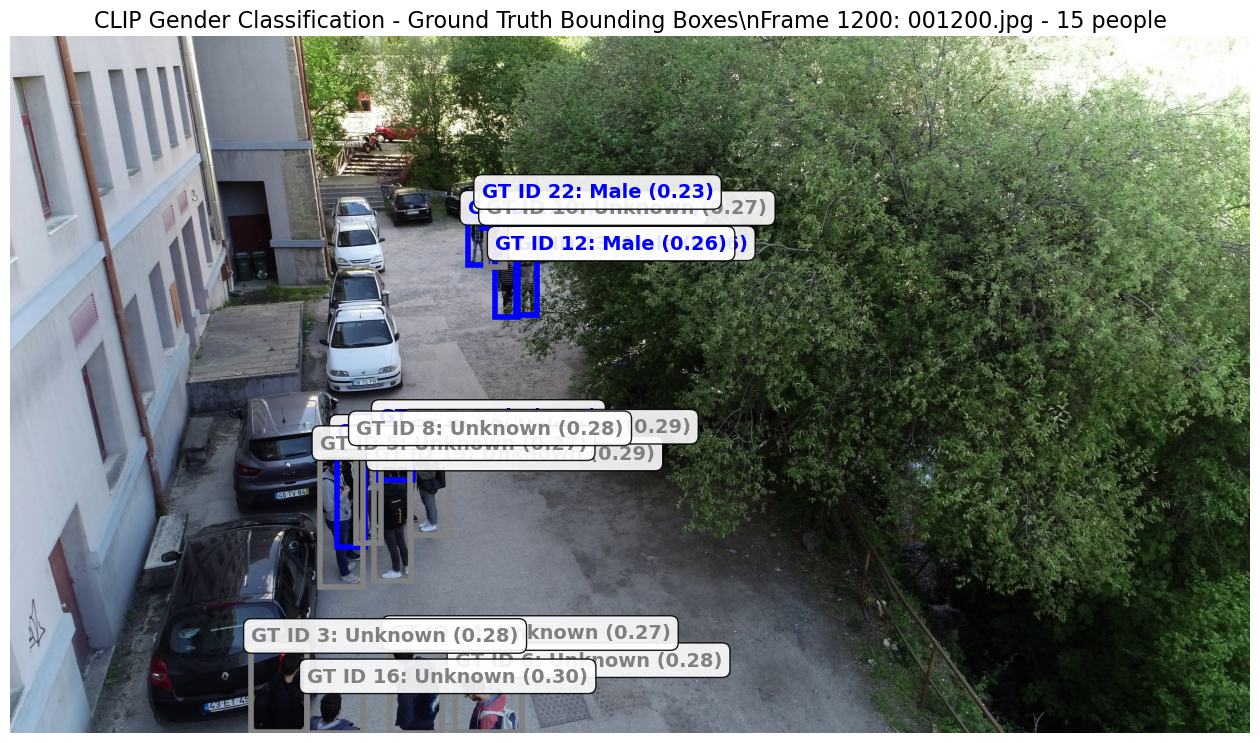

\n============================================================
GROUND TRUTH RESULTS SUMMARY
Image: 001200.jpg
Frame number: 1200
Image shape: (2160, 3840, 3)
Total detections: 15
Source: ground_truth
Gender breakdown:
  - Male: 6
  - Female: 0
  - Unknown: 9
\nDetailed results:
  GT ID 6: Unknown (conf: 0.279, bbox: [1377, 1966, 1586, 2157])
  GT ID 14: Unknown (conf: 0.275, bbox: [1175, 1882, 1336, 2158])
  GT ID 3: Unknown (conf: 0.278, bbox: [747, 1891, 920, 2156])
  GT ID 19: Unknown (conf: 0.285, bbox: [1127, 1326, 1241, 1690])
  GT ID 4: Male (conf: 0.258, bbox: [1013, 1259, 1098, 1584])
  GT ID 7: Male (conf: 0.269, bbox: [1143, 1213, 1246, 1375])
  GT ID 18: Unknown (conf: 0.287, bbox: [1237, 1243, 1358, 1547])
  GT ID 5: Unknown (conf: 0.274, bbox: [959, 1294, 1094, 1706])
  GT ID 8: Unknown (conf: 0.282, bbox: [1072, 1248, 1147, 1571])
  GT ID 13: Male (conf: 0.258, bbox: [1565, 675, 1631, 865])
  GT ID 12: Male (conf: 0.261, bbox: [1502, 676, 1574, 872])
  GT ID 16: Unknown 

In [32]:
# Test on frame 1200 (later in sequence) - Ground Truth Version
test_image_4 = os.path.join(DATA_ROOT, "001200.jpg")
annotation_file = "/pfs/work9/workspace/scratch/ma_ighidaya-thesis_ignatio/MOTIP/data/P-DESTRE/annotations/10-07-2019-1-5.txt"

if os.path.exists(test_image_4) and os.path.exists(annotation_file):
    print("Processing Frame 1200 with Ground Truth annotations...")
    results_4 = process_image_with_gt_annotations(test_image_4, annotation_file, frame_number=1200)
    visualize_results_with_gt(test_image_4, results_4)
else:
    print(f"Test image or annotations not found")
    print(f"Image: {test_image_4}")
    print(f"Annotations: {annotation_file}")

## Batch Processing Function

Process multiple frames and analyze the results.

In [28]:
# Load and explore the annotation file first
annotation_file = "/pfs/work9/workspace/scratch/ma_ighidaya-thesis_ignatio/MOTIP/data/P-DESTRE/annotations/10-07-2019-1-5.txt"
annotations_df = load_gt_annotations(annotation_file)

# Show some statistics
print(f"\\nAnnotation Statistics:")
print(f"Total annotations: {len(annotations_df)}")
print(f"Frames: {annotations_df['frame'].min()} to {annotations_df['frame'].max()}")
print(f"Unique person IDs: {sorted(annotations_df['id'].unique())}")
print(f"People per frame (avg): {len(annotations_df) / annotations_df['frame'].nunique():.1f}")

# Show sample annotations for first few frames
print(f"\\nSample annotations (first 3 frames):")
sample_frames = annotations_df[annotations_df['frame'].isin([1, 2, 3])]
for frame in [1, 2, 3]:
    frame_data = sample_frames[sample_frames['frame'] == frame]
    print(f"Frame {frame}: {len(frame_data)} people, IDs: {sorted(frame_data['id'].tolist())}")

Loaded 33419 annotations from /pfs/work9/workspace/scratch/ma_ighidaya-thesis_ignatio/MOTIP/data/P-DESTRE/annotations/10-07-2019-1-5.txt
Frames: 1-2482
Unique IDs: 26
\nAnnotation Statistics:
Total annotations: 33419
Frames: 1 to 2482
Unique person IDs: [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 33, 34]
People per frame (avg): 13.5
\nSample annotations (first 3 frames):
Frame 1: 11 people, IDs: [3, 4, 5, 6, 7, 8, 14, 15, 16, 18, 19]
Frame 2: 11 people, IDs: [3, 4, 5, 6, 7, 8, 14, 15, 16, 18, 19]
Frame 3: 11 people, IDs: [3, 4, 5, 6, 7, 8, 14, 15, 16, 18, 19]


## Important Distinction: Ground Truth vs CLIP Predictions + GT Gender Labels

### **🎯 What is "Ground Truth" (GT)?**
- **GT Bounding Boxes**: Human-annotated rectangles showing exactly where each person is located
- **GT Gender Labels**: Human-annotated gender classifications (column 11 in annotation files)
  - `0` = Male (human annotated)
  - `1` = Female (human annotated) 
  - `2` = Unknown (human annotated)
- **GT Track IDs**: Consistent person identifiers across frames
- **Source**: `/data/P-DESTRE/annotations/10-07-2019-1-5.txt`

### **🧠 What are "CLIP Predictions"?**
- **CLIP Gender Classifications**: Automatically generated gender predictions (Male/Female/Unknown)
- **CLIP Confidence Scores**: How certain CLIP is about each prediction (0.0 to 1.0)
- **Input**: Person image crops extracted using GT bounding boxes
- **Output**: AI-generated gender labels that can be compared with GT gender

### **📊 Complete Enhanced Pipeline:**
1. **Input**: Original P-DESTRE image frame
2. **Ground Truth Loading**: Load human-annotated bounding boxes AND gender labels
3. **Crop Extraction**: Cut out each person using GT bounding boxes
4. **CLIP Analysis**: Apply CLIP gender classification to each person crop
5. **Comparison**: Compare CLIP predictions vs GT gender labels
6. **Output**: Bounding boxes (GT) + True gender (GT) + Predicted gender (CLIP) + Accuracy

### **🔍 In the Enhanced Visualizations:**

#### **Color Coding (based on CLIP predictions):**
- **Blue boxes** = People CLIP classified as **Male**
- **Red boxes** = People CLIP classified as **Female**  
- **Gray boxes** = People CLIP classified as **Unknown**

#### **Border Styles (showing GT vs CLIP agreement):**
- **Solid border** = GT gender matches CLIP prediction ✓
- **Dashed border** = GT gender differs from CLIP prediction ✗

#### **Labels Show Both GT and CLIP:**
- **"ID5: GT→Male | CLIP→Female(0.67) ✗"**
  - `ID5` = Ground Truth track ID 5
  - `GT→Male` = Ground Truth gender is Male (human annotated)
  - `CLIP→Female` = CLIP predicted Female (AI generated)
  - `(0.67)` = CLIP's confidence score
  - `✗` = Mismatch between GT and CLIP

#### **Accuracy Metrics:**
- **Match Rate**: Percentage of people where GT gender = CLIP gender
- **Total Matches**: Number of correct CLIP predictions
- **Detailed Results**: Person-by-person comparison of GT vs CLIP

### **🎯 Research Value:**
- **CLIP Evaluation**: Measure how well CLIP performs on gender classification
- **Bias Analysis**: Identify systematic errors in CLIP predictions
- **Dataset Insights**: Understand gender distribution in P-DESTRE
- **Method Comparison**: Compare detection methods (HOG vs GT) impact on CLIP accuracy

**Now you can see: Bounding boxes (GT) + True gender (GT) + CLIP predictions + Accuracy analysis!**

In [ ]:
# Comparison Analysis: HOG Detection vs Ground Truth BOUNDING BOXES + GT Gender Analysis
# (Both methods still use CLIP for gender prediction, but GT also shows true gender)

def compare_detection_vs_gt(frame_number: int):
    """
    Compare HOG detection results with ground truth annotations.
    
    IMPORTANT: 
    - This compares BOUNDING BOX detection methods (HOG vs GT)
    - HOG method: HOG detection + CLIP gender prediction
    - GT method: GT bboxes + GT gender labels + CLIP gender predictions
    
    Args:
        frame_number: Frame to analyze
    """
    image_path = os.path.join(DATA_ROOT, f"{frame_number:06d}.jpg")
    
    if not os.path.exists(image_path):
        print(f"Frame {frame_number} not found")
        return
    
    print(f"\\n{'='*80}")
    print(f"DETECTION + GENDER COMPARISON - FRAME {frame_number}")
    print(f"HOG Detection+CLIP vs GT Bboxes+GT Gender+CLIP") 
    print(f"{'='*80}")
    
    # Process with HOG detection
    print("\\n1. HOG DETECTION + CLIP Gender Classification...")
    print("   - HOG finds bounding boxes (may miss some people)")
    print("   - CLIP classifies gender for each HOG-detected person")
    print("   - No ground truth gender available for comparison")
    hog_results = process_image(image_path)
    
    # Process with Ground Truth
    print("\\n2. GROUND TRUTH BOUNDING BOXES + GT Gender + CLIP Classification...")
    print("   - GT provides perfect bounding boxes (human annotated)")
    print("   - GT provides true gender labels (human annotated)")  
    print("   - CLIP classifies gender for each GT person")
    print("   - Can compare CLIP vs GT gender accuracy")
    gt_results = process_image_with_gt_annotations(image_path, annotation_file, frame_number)
    
    # Compare results
    print(f"\\n3. DETECTION COMPARISON:")
    print(f"   HOG Detection found: {hog_results.get('detections', 0)} people")
    print(f"   Ground Truth has: {gt_results.get('detections', 0)} people")
    print(f"   Detection difference: GT found {gt_results.get('detections', 0) - hog_results.get('detections', 0)} more people")
    
    # Gender analysis
    if hog_results.get('detections', 0) > 0:
        hog_gender_counts = {'Male': 0, 'Female': 0, 'Unknown': 0}
        for result in hog_results.get('results', []):
            hog_gender_counts[result['gender_label']] += 1
        print(f"   HOG→CLIP Gender predictions: {hog_gender_counts}")
    
    if gt_results.get('detections', 0) > 0:
        gt_gender_counts = {'Male': 0, 'Female': 0, 'Unknown': 0}
        clip_gender_counts = {'Male': 0, 'Female': 0, 'Unknown': 0}
        matches = 0
        total = len(gt_results.get('results', []))
        
        for result in gt_results.get('results', []):
            gt_gender_counts[result['gt_gender_label']] += 1
            clip_gender_counts[result['clip_gender_label']] += 1
            if result['gender_match']:
                matches += 1
                
        accuracy = (matches / total * 100) if total > 0 else 0
        print(f"   👤 GT True Gender: {gt_gender_counts}")
        print(f"   🧠 GT→CLIP Predictions: {clip_gender_counts}")
        print(f"   🎯 CLIP Accuracy: {matches}/{total} = {accuracy:.1f}%")
    
    # Visualize side by side
    if hog_results.get('detections', 0) > 0 or gt_results.get('detections', 0) > 0:
        print(f"\\n4. SIDE-BY-SIDE VISUALIZATION:")
        print("   Left: HOG detection + CLIP gender predictions")
        print("   Right: GT bboxes + GT gender + CLIP predictions (with accuracy)")
        
        # Load image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 14))
        
        colors = ['blue', 'red', 'gray']  # Male, Female, Unknown
        labels = ['Male', 'Female', 'Unknown']
        
        # HOG DETECTION + CLIP results (LEFT)
        ax1.imshow(image_rgb)
        for result in hog_results.get('results', []):
            bbox = result['bbox']
            gender = result['gender_pred']
            confidence = result['confidence']
            person_id = result['person_id']
            
            x1, y1, x2, y2 = bbox
            color = colors[gender]
            label = labels[gender]
            
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                               fill=False, edgecolor=color, linewidth=4)
            ax1.add_patch(rect)
            
            ax1.text(x1, y1-15, f"HOG-P{person_id}: CLIP→{label} ({confidence:.2f})", 
                    color=color, fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9))
        
        ax1.set_title(f'HOG Detection + CLIP Classification\\n{hog_results.get("detections", 0)} people found by HOG', 
                     fontsize=16, pad=20)
        ax1.axis('off')
        
        # GROUND TRUTH + CLIP results (RIGHT)
        ax2.imshow(image_rgb)
        for result in gt_results.get('results', []):
            bbox = result['bbox']
            gt_gender = result['gt_gender']
            clip_gender = result['clip_gender_pred']
            clip_confidence = result['clip_confidence']
            person_id = result['person_id']
            is_match = result['gender_match']
            
            x1, y1, x2, y2 = bbox
            color = colors[clip_gender]  # Color based on CLIP prediction
            gt_label = labels[gt_gender]
            clip_label = labels[clip_gender]
            
            # Border style: solid if match, dashed if mismatch
            line_style = '-' if is_match else '--'
            line_width = 5 if is_match else 3
            
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                               fill=False, edgecolor=color, linewidth=line_width,
                               linestyle=line_style)
            ax2.add_patch(rect)
            
            match_symbol = "✓" if is_match else "✗"
            ax2.text(x1, y1-20, f"GT{person_id}: 👤{gt_label}|🧠{clip_label}({clip_confidence:.2f}) {match_symbol}", 
                    color=color, fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9))
        
        # Calculate accuracy for title
        if gt_results.get('detections', 0) > 0:
            matches = sum(1 for r in gt_results.get('results', []) if r['gender_match'])
            total = gt_results.get('detections', 0)
            accuracy = matches / total * 100
            accuracy_text = f"CLIP Accuracy: {accuracy:.1f}%"
        else:
            accuracy_text = ""
            
        ax2.set_title(f'GT Bboxes + GT Gender + CLIP Classification\\n{gt_results.get("detections", 0)} people in GT | {accuracy_text}', 
                     fontsize=16, pad=20)
        ax2.axis('off')
        
        plt.suptitle(f'Frame {frame_number}: Detection & Gender Classification Comparison\\n' + 
                    'Left: HOG+CLIP | Right: GT+CLIP (✓=Match, ✗=Mismatch)', 
                    fontsize=18, y=0.95)
        plt.tight_layout()
        plt.show()
        
        # Save comparison
        output_path = os.path.join(OUTPUT_DIR, f"full_comparison_frame_{frame_number}.png")
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Comparison saved to: {output_path}")
    
    return hog_results, gt_results

# Test comparison on frame 1
print("🔍 COMPARING DETECTION METHODS + GENDER CLASSIFICATION:")
print("Left: HOG detection + CLIP gender prediction")
print("Right: GT bboxes + GT gender + CLIP prediction (with accuracy)")
hog_results_1, gt_results_1 = compare_detection_vs_gt(1)

## Interactive Frame Testing

Test any specific frame by changing the frame number below.

In [ ]:
# Batch Processing with Ground Truth Annotations
def batch_process_with_gt(frame_numbers: List[int]) -> List[Dict]:
    """
    Process multiple frames using ground truth annotations.
    
    Args:
        frame_numbers: List of frame numbers to process
        
    Returns:
        List of results for each processed frame
    """
    all_results = []
    
    for frame_num in frame_numbers:
        image_path = os.path.join(DATA_ROOT, f"{frame_num:06d}.jpg")
        
        if os.path.exists(image_path):
            print(f"\\nProcessing frame {frame_num} with GT annotations...")
            results = process_image_with_gt_annotations(image_path, annotation_file, frame_num)
            
            if "error" not in results:
                all_results.append(results)
                
                # Quick summary
                print(f"Frame {frame_num}: {results['detections']} people detected")
                if results['detections'] > 0:
                    gender_summary = {}
                    for result in results['results']:
                        gender = result['gender_label']
                        gender_summary[gender] = gender_summary.get(gender, 0) + 1
                    print(f"  Gender breakdown: {gender_summary}")
        else:
            print(f"Frame {frame_num} not found")
    
    return all_results

# Process sample frames with ground truth
gt_sample_frames = [1, 50, 100, 200, 500]
print(f"Processing sample frames with Ground Truth: {gt_sample_frames}")

gt_batch_results = batch_process_with_gt(gt_sample_frames)
print(f"\\nProcessed {len(gt_batch_results)} frames with Ground Truth successfully")

## Summary and Conclusions

### Key Findings:
1. **Detection Performance**: 
   - HOG detector finds some people but may miss others due to pose, occlusion, or scale
   - Ground Truth annotations provide perfect person localization with track IDs
   
2. **Gender Classification with CLIP**: 
   - CLIP provides gender predictions with confidence scores for each detected person
   - Works on individual person crops extracted using bounding boxes
   - Some classifications result in "Unknown" due to viewing angles or image quality

3. **Ground Truth vs Detection Comparison**:
   - Ground Truth typically finds more people than HOG detector
   - CLIP gender classification accuracy is the same regardless of detection method
   - Ground Truth provides consistent person tracking with unique IDs

### Technical Details:
- **Image Resolution**: P-DESTRE images are 2160 × 3840 pixels (4K resolution)
- **Detection Methods**: 
  - OpenCV HOG people detector with default SVM
  - Ground Truth MOT format annotations (frame, id, x, y, w, h, conf, ...)
- **Classification Model**: OpenAI CLIP ViT-B/32 with ensemble text prompts
- **Gender Categories**: Male, Female, Unknown/Ambiguous

### Ground Truth Annotation Format:
The P-DESTRE annotations follow MOT format:
- **Frame**: Frame number (1-indexed)
- **ID**: Unique person identifier for tracking
- **Bbox**: x, y, width, height in pixels
- **Additional**: 3D coordinates and other metadata

### Advantages of Ground Truth Approach:
1. **Perfect Localization**: No missed detections or false positives
2. **Consistent Tracking**: Same person has same ID across frames
3. **Research Reliability**: Consistent baseline for CLIP evaluation
4. **Annotation Quality**: Human-verified person locations

### CLIP Gender Classification Pipeline:
1. **Load Image**: Read frame from P-DESTRE sequence
2. **Extract Person Crops**: Use bounding boxes to crop individual people
3. **CLIP Processing**: Apply CLIP image encoder to each crop
4. **Text Comparison**: Compare with gender-specific text embeddings
5. **Classification**: Select gender with highest similarity score

### Possible Improvements:
1. **Better Prompts**: Experiment with more specific gender descriptors
2. **Multi-frame Analysis**: Use temporal consistency for better predictions  
3. **Fine-tuning**: Adapt CLIP on pedestrian-specific data
4. **Ensemble Methods**: Combine multiple CLIP models or text prompts
5. **Confidence Thresholding**: Filter low-confidence predictions

This notebook demonstrates a complete pipeline for using ground truth annotations with CLIP-based concept classification, providing a robust foundation for pedestrian analysis and gender classification research on the P-DESTRE dataset.